## Perform all overhead operations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Import and combine the desired data files.

In [2]:
turnstile_files = ("MTA_Data/turnstile_200905.txt", "MTA_Data/turnstile_200912.txt", "MTA_Data/turnstile_200919.txt")
turnstile_data = (pd.read_csv(file) for file in turnstile_files)
turnstiles = pd.concat(turnstile_data)

## Process the data.

In [3]:
turnstiles = turnstiles.loc[turnstiles['TIME'] == '00:00:00']
turnstiles["DATE_TIME"] = pd.to_datetime(turnstiles['DATE'])
sorted_turnstiles = turnstiles.sort_values(['C/A', 'UNIT', 'STATION', 'SCP', 'DATE_TIME'])

## Calculate the number of passes through each turnstile for each day.

In [4]:
sorted_turnstiles['daily_entries'] = 0
for i in range(len(sorted_turnstiles) - 1):
    if sorted_turnstiles.iloc[i]['SCP'] == sorted_turnstiles.iloc[i + 1]['SCP']:
        sorted_turnstiles.iat[i, 12] = sorted_turnstiles.iloc[i + 1]['ENTRIES'] - sorted_turnstiles.iloc[i]['ENTRIES']
    else:
        sorted_turnstiles.iat[i, 12] = None

## Create turnstile groups.

In [5]:
turns_group = sorted_turnstiles.groupby(['C/A', 'UNIT', 'STATION', 'SCP'])

## Plot the number of turns versus the date for a selected turnstile.

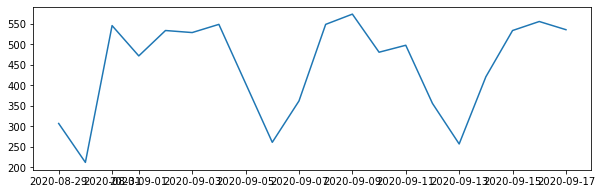

In [6]:
turnstile = turns_group.get_group(('A002', 'R051', '59 ST', '02-00-00'))
plt.figure(figsize=(10,3))
plt.plot(turnstile['DATE_TIME'], turnstile['daily_entries'])